# Visualizing CAPE/CIN changes in FUTR 4.5 and 8.5

In [1]:
import xarray as xr
import numpy as np

import warnings
warnings.simplefilter("ignore", UserWarning)

geog = xr.open_dataset("../data/geog/geog_sim.nc")

lons, lats = geog.CLONG.values[0,:,:], geog.CLAT.values[0,:,:]

# Read in seasonal means

In [2]:
hist_seas = xr.open_dataset("../data/thermo/HIST_seasonal_MUCAPE_MUCIN.nc")
rcp45_seas = xr.open_dataset("../data/thermo/FUTR45_seasonal_MUCAPE_MUCIN.nc")
rcp85_seas = xr.open_dataset("../data/thermo/FUTR85_seasonal_MUCAPE_MUCIN.nc")

# Plotting setup

In [3]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.ndimage import gaussian_filter
from grl2022.mapping.ax import setup_map
from grl2022.mapping.colors import get_cmap

titles = {'HIST': {"title": "{} Mean {} (filled)\nand Mean {} (hatched)", "clabel": 'J kg$^{-1}$'},
          'FUTR 4.5': {"title": "{} Change in Mean {} (filled)\nand Mean {} (hatched)", "clabel": '$\Delta$ J kg$^{-1}$'},
          'FUTR 8.5': {"title": "{} Change in Mean {} (filled)\nand Mean {} (hatched)", "clabel": '$\Delta$ J kg$^{-1}$'}}

labels = {'AFWA_CAPE_MU': "MU CAPE", 
          'AFWA_CIN_MU': 'MU CIN'}  

# Map the data

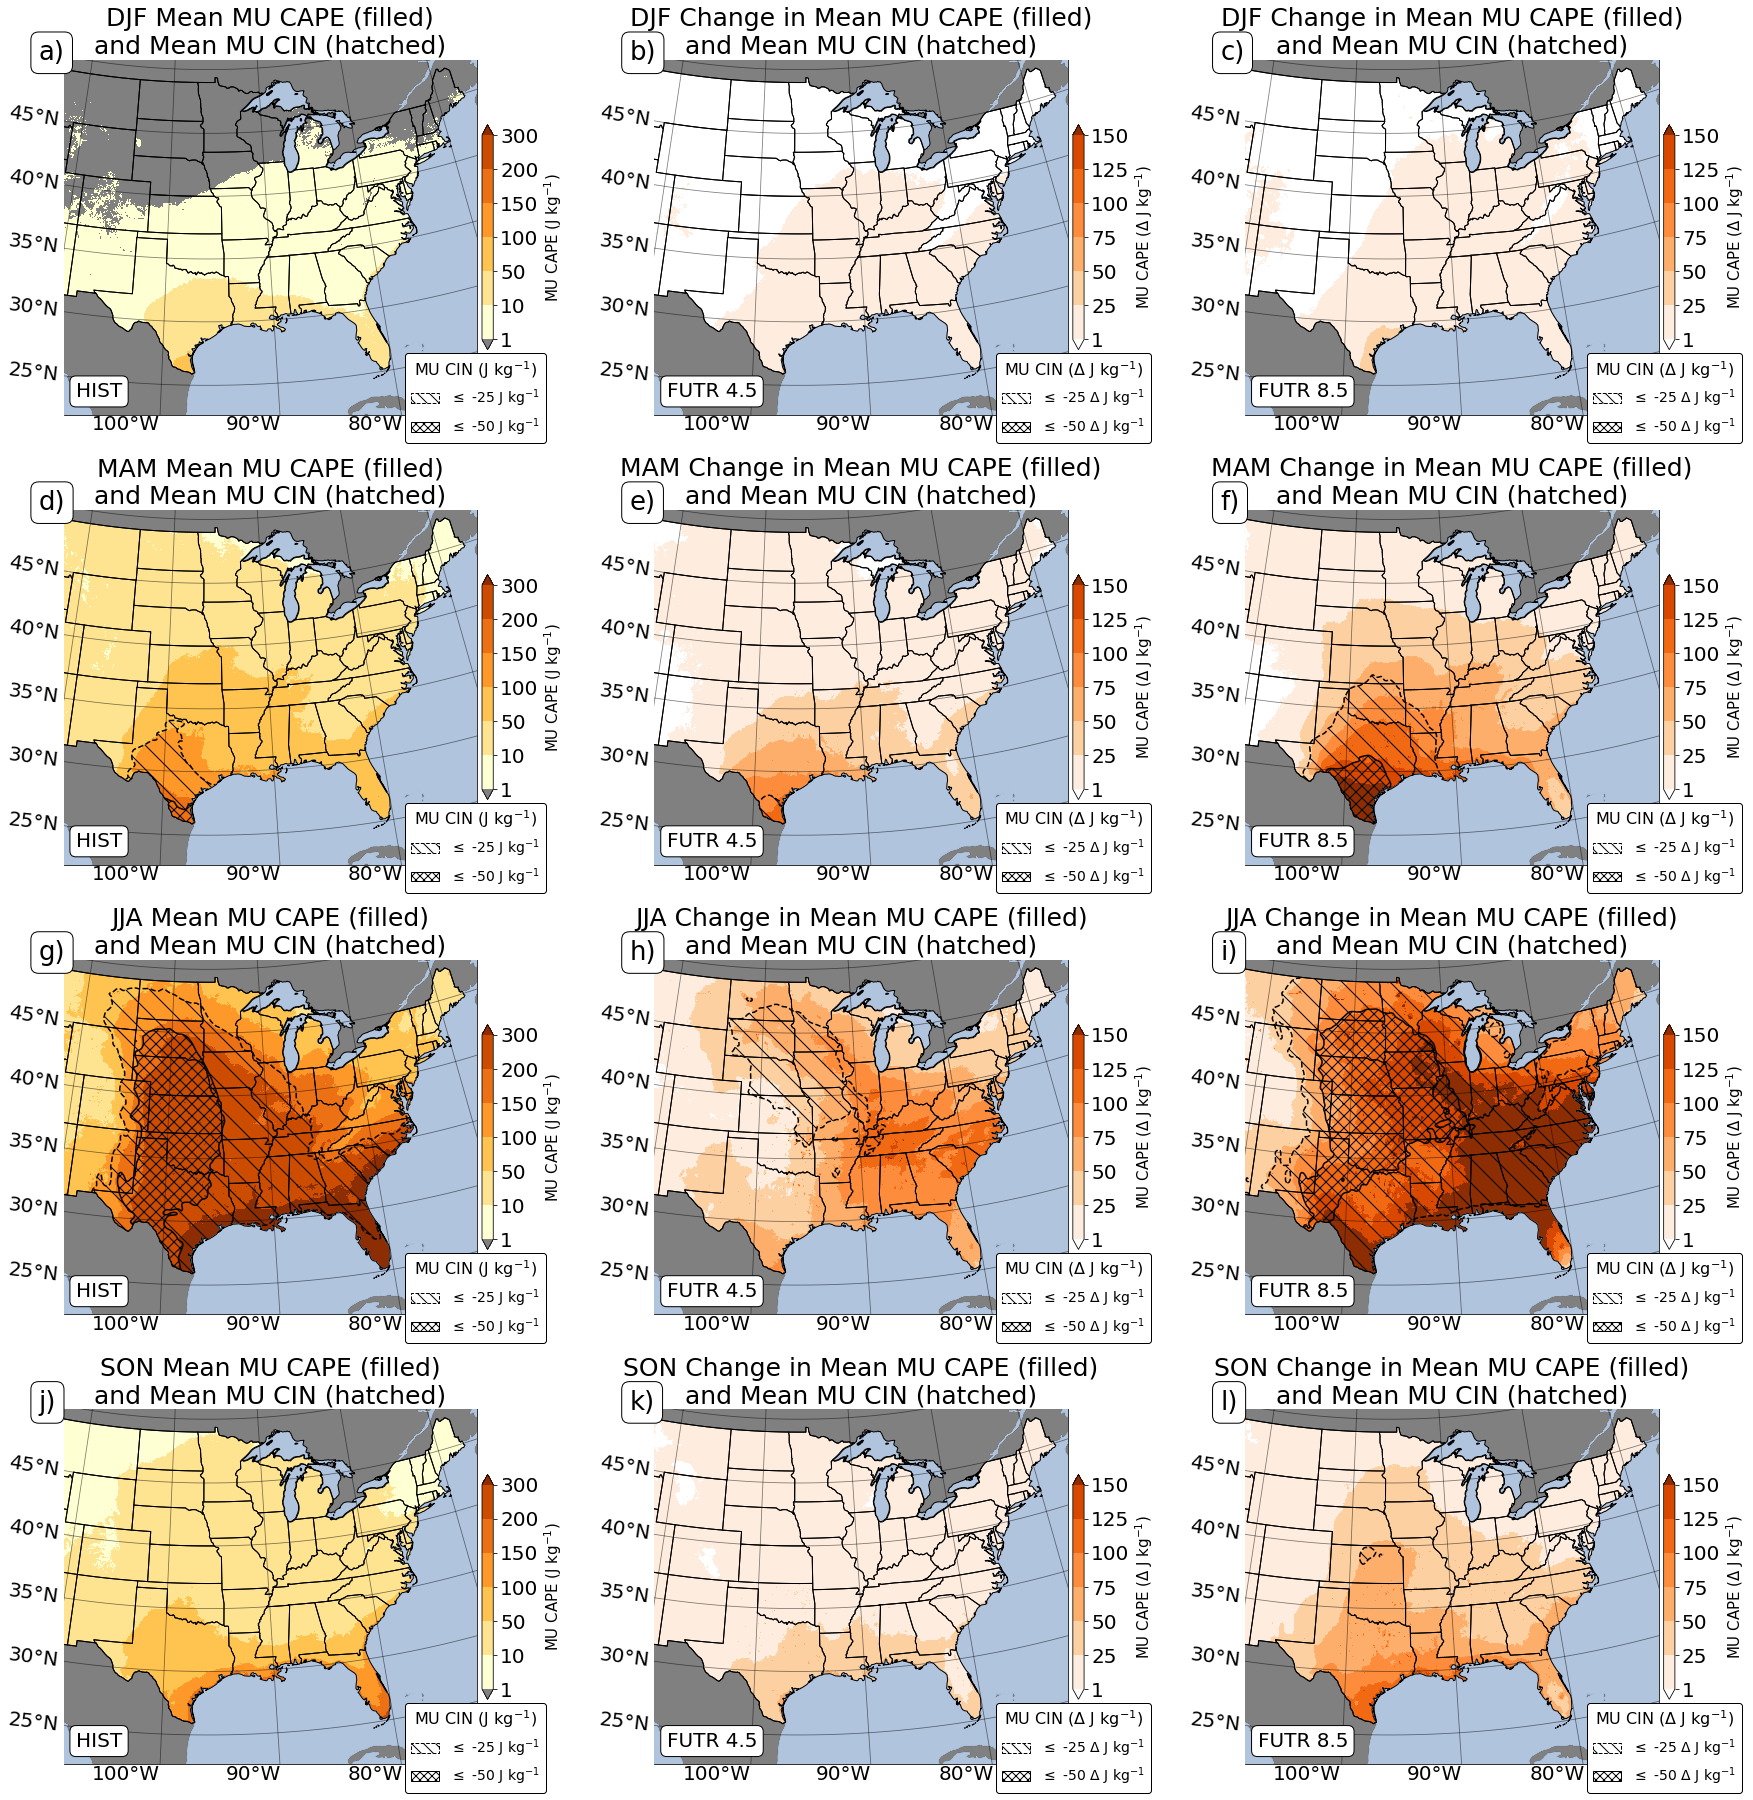

In [4]:
plt.rcParams['figure.figsize'] = 30, 40 

for row, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    
    hist_seas_ = hist_seas.sel(season=season)
    rcp45_seas_ = rcp45_seas.sel(season=season)
    rcp85_seas_ = rcp85_seas.sel(season=season)
    
    for col, (sim_name, sim_data) in enumerate(zip(['HIST', 'FUTR 4.5', 'FUTR 8.5'], [hist_seas_, rcp45_seas_, rcp85_seas_])):
    
        ax = setup_map(row, col, 5, 3)
        ax.set_title(titles[sim_name]['title'].format(season, 'MU CAPE', 'MU CIN'), fontsize=25)
        norm, cmap = get_cmap(sim_name, 'AFWA_CAPE_MU')
        
        if sim_name == 'HIST':
            
            cape = sim_data['AFWA_CAPE_MU']
            cin = gaussian_filter(hist_seas_['AFWA_CIN_MU'], 4)
            
        else:
            
            cape = sim_data['AFWA_CAPE_MU'] - hist_seas_['AFWA_CAPE_MU']
            cape = np.ma.masked_where((sim_data['AFWA_CAPE_MU'] == 0) & (hist_seas_['AFWA_CAPE_MU'] == 0), cape)
            
            cin = sim_data['AFWA_CIN_MU'] - hist_seas_['AFWA_CIN_MU']
            cin = gaussian_filter(cin, 4)
            

        mmp = ax.pcolormesh(lons, lats, cape, cmap=cmap, norm=norm, 
                            transform=ccrs.PlateCarree(), shading='nearest', rasterized = True, zorder=5)

        cbar = plt.colorbar(mmp, ax=ax, pad=0.01, shrink=0.6, extend='both')
        cbar.ax.tick_params(labelsize=20)
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(label="MU CAPE (" + titles[sim_name]['clabel'] + ")", size=15) 

        

        cl = ax.contourf(lons, lats, cin, colors='None', edgecolor=['grey', 'k'], hatches=['xx', '\\'], levels=[-1000, -50, -25], transform=ccrs.PlateCarree(), zorder=5)
        ax.contour(lons, lats, cin, colors=['k'], levels=[-1000, -50, -25], linestyles=['dashed', 'solid'], transform=ccrs.PlateCarree(), zorder=5)

        ax.annotate(sim_name, (0.03,0.05), xycoords='axes fraction',fontsize=20, 
                    bbox=dict(boxstyle='round', facecolor='w', alpha=1), color='k',zorder=25)
        
        f25 = mpatches.Patch(facecolor='None',hatch=r'\\', edgecolor='k', linestyle='--', label='$\leq$ -25 {}'.format(titles[sim_name]['clabel']))
        f50 = mpatches.Patch(facecolor='None',hatch=r'xxx', edgecolor='k', label='$\leq$ -50 {}'.format(titles[sim_name]['clabel']))

        a = ax.legend(title="MU CIN (" + titles[sim_name]['clabel'] + ")", handles = [f25, f50], 
                      title_fontsize=16, fontsize=14, framealpha=1, loc='lower left', edgecolor='k', bbox_to_anchor=(0.81,-0.1)).set_zorder(10)
    

plt.savefig("../figures/fig4.pdf", bbox_inches='tight', dpi=300)    